In [1]:
import numpy as np
from sklearn.decomposition import PCA
import scipy.io as sio
from sklearn.model_selection import train_test_split
import random
from tensorflow.keras import utils as np_utils
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, precision_recall_fscore_support
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
!pip install spectral

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.9/212.9 kB 6.3 MB/s eta 0:00:00


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import svd, pinv
from sklearn.decomposition import PCA
import spectral as spy
import matplotlib.patches as mpatches

In [4]:
# import numpy as np
# import matplotlib.pyplot as plt

# from sklearn.decomposition import PCA

# def hysime(data, noise=None):
#     """
#     Perform HySime to estimate the number of endmembers.

#     Parameters:
#         data (numpy.ndarray): Hyperspectral data (3D array: height x width x bands).
#         noise (numpy.ndarray, optional): Noise data (same shape as data).

#     Returns:
#         int: Estimated number of endmembers.
#     """
#     # Flatten spatial dimensions into 2D: (pixels, bands)
#     data_flat = data.reshape(-1, data.shape[-1])

#     # Calculate covariance matrix of the data
#     covariance_matrix = np.cov(data_flat.T)

#     if noise is not None:
#         # Flatten noise to match data dimensions
#         noise_flat = noise.reshape(-1, noise.shape[-1])
#         # Estimate noise covariance matrix
#         noise_covariance_matrix = np.cov(noise_flat.T)
#     else:
#         # Default to a very small noise covariance matrix if noise not provided
#         noise_covariance_matrix = np.zeros_like(covariance_matrix)

#     # Compute signal covariance matrix (data covariance - noise covariance)
#     signal_covariance_matrix = covariance_matrix - noise_covariance_matrix

#     # Perform eigen decomposition of the signal covariance matrix
#     eig_values, eig_vectors = np.linalg.eig(signal_covariance_matrix)

#     # Sort eigenvalues in descending order
#     eig_values_sorted = np.sort(eig_values)[::-1]

#     # Determine the number of eigenvalues above a threshold
#     threshold = 0.01  # Adjust based on your dataset
#     num_endmembers = np.sum(eig_values_sorted > threshold)

#     return num_endmembers



# # Assuming 'hyperspectral_data' is already loaded
# # Data shape and stats
# print(f"Data shape: {hyperspectral_data.shape}")
# print(f"Min value: {np.min(hyperspectral_data)}, Max value: {np.max(hyperspectral_data)}")

# # Eigenvalue computation
# def compute_eigenvalues(data):
#     data_flat = data.reshape(-1, data.shape[-1])  # Flatten spatial dimensions
#     covariance_matrix = np.cov(data_flat.T)
#     eig_values, eig_vectors = np.linalg.eig(covariance_matrix)
#     return np.real(eig_values), np.real(eig_vectors)

# eig_values, eig_vectors = compute_eigenvalues(hyperspectral_data)

# # Plot Eigenvalue Spectrum
# plt.figure(figsize=(8, 6))
# plt.plot(np.sort(eig_values)[::-1], '-o', label="Eigenvalue")
# plt.xlabel('Index')
# plt.ylabel('Eigenvalue')
# plt.title('Eigenvalue Spectrum')
# plt.legend()
# plt.show()

# print(f"Top 10 eigenvalues: {np.sort(eig_values)[::-1][:10]}")

# # HySime estimation (default)

# estimated_endmembers = hysime(hyperspectral_data)
# print(f"Estimated number of endmembers: {estimated_endmembers}")


# # ===================== REFINEMENTS =====================

# # Step 1: Adjust noise scaling
# noise_factor = 2.0  # Scale noise variance
# noise = np.random.normal(scale=0.01, size=hyperspectral_data.shape)  # Example noise array
# noise_scaled = noise * noise_factor


# estimated_endmembers_noise_scaled = hysime(hyperspectral_data, noise=noise_scaled)
# print(f"Number of endmembers (noise factor {noise_factor}): {estimated_endmembers_noise_scaled}")

# # Step 2: Eigenvalue threshold
# threshold = 0.01  # Filter eigenvalues below threshold
# num_significant_components = np.sum(eig_values >= threshold)
# print(f"Number of components above threshold ({threshold}): {num_significant_components}")

# # Step 3: Subsampling hyperspectral bands
# subsample_factor = 3  # Take every 3rd band
# reduced_data = hyperspectral_data[:, :, ::subsample_factor]
# print(f"Reduced data shape after subsampling: {reduced_data.shape}")


# estimated_endmembers_subsampled = hysime(reduced_data)
# print(f"Number of endmembers (subsample factor {subsample_factor}): {estimated_endmembers_subsampled}")

# # Step 4: PCA-based dimensionality reduction
# # Flatten spatial dimensions for PCA
# data_2d = hyperspectral_data.reshape(-1, hyperspectral_data.shape[-1])
# pca = PCA(n_components=0.99)  # Retain 99% variance
# reduced_data_pca = pca.fit_transform(data_2d)

# print(f"Reduced data shape after PCA: {reduced_data_pca.shape}")


# estimated_endmembers_pca = hysime(reduced_data_pca)
# print(f"Number of endmembers after PCA: {estimated_endmembers_pca}")

# # ===================== PLOT CUMULATIVE VARIANCE =====================
# # Plot explained variance from PCA
# explained_variance_ratio = pca.explained_variance_ratio_
# cumulative_variance = np.cumsum(explained_variance_ratio)

# plt.figure(figsize=(8, 6))
# plt.plot(cumulative_variance, label='Cumulative Variance')
# plt.axhline(y=0.99, color='r', linestyle='--', label='Variance Threshold (99%)')
# plt.xlabel('Number of Components')
# plt.ylabel('Explained Variance')
# plt.title('Cumulative Explained Variance')
# plt.legend()
# plt.show()

# print(f"Number of endmembers (variance threshold 99.0%): {np.sum(cumulative_variance <= 0.99)}")


In [5]:
def hypermnf(cube, numComponents, mean_centered=True):
    h, w, channels = cube.shape
    cube = cube.reshape(h * w, channels)

    if mean_centered:
        u = np.mean(cube, axis=0)
        cube -= u

    V = np.diff(cube, axis=0)
    V = computeCov(V)

    U, S, _ = svd(V, full_matrices=False)
    getNonZeros = np.sum(S != 0)
    U = U[:, :getNonZeros]

    noiseWhitening = np.dot(U, np.diag(1 / np.sqrt(S[:getNonZeros]))).T

    cube = np.dot(noiseWhitening, cube.T).T

    pca = PCA(n_components=numComponents, svd_solver='full')
    reduced_cube = pca.fit_transform(cube)

    coeff = np.dot(pca.components_.T, noiseWhitening.T)

    return reduced_cube.reshape(h, w, numComponents), coeff

In [6]:
def computeCov(cube):
    return np.cov(cube, rowvar=False)

In [7]:
def MaxD_Endmembers(MData, MData2, N):
    Data = MData.T
    Data1 = MData2.T
    nb, pix = Data.shape
    npc, _ = Data1.shape
    magnitude = np.sum(Data**2, axis=0)
    idx1 = np.argmax(magnitude)
    idx2 = np.argmin(magnitude)

    Endmembers = np.zeros((npc, N))
    idxEndmembers = np.zeros(N, dtype=int)

    Endmembers[:, 0] = Data[:, idx1]
    Endmembers[:, 1] = Data[:, idx2]
    idxEndmembers[0] = idx1
    idxEndmembers[1] = idx2

    Data_proj = Data1.copy()
    Id = np.eye(npc)

    for k in range(2, N):
        difference1 = Data_proj[:, idx2] - Data_proj[:, idx1]
        Dps = pinv(difference1[:, np.newaxis])
        ProjD = Id - np.dot(difference1[:, np.newaxis], Dps)
        Data_proj = np.dot(ProjD, Data_proj)
        idx1 = idx2
        Res = np.sum((Data_proj[:, idx2][:, np.newaxis] - Data_proj) ** 2, axis=0)
        idx2 = np.argmax(Res)
        Endmembers[:, k] = Data[:, idx2]
        idxEndmembers[k] = idx2

    return Endmembers, idxEndmembers

In [8]:
def local_gram(Endmembers):
    return np.dot(Endmembers.T, Endmembers)

In [9]:
def general_gram(Endmembers):
    mean_endmembers = np.mean(Endmembers, axis=1)
    centered_endmembers = Endmembers - mean_endmembers[:, np.newaxis]
    return np.dot(centered_endmembers.T, centered_endmembers)

In [10]:
def cal_vol_func(Data, MNF_data, num_endmembers):
    loc_gram_fcn = np.zeros(num_endmembers)
    gen_gram_fcn = np.zeros(num_endmembers)

    for i in range(2, num_endmembers):
        Endmembers, _ = MaxD_Endmembers(Data, MNF_data, i + 1)
        loc_gram = local_gram(Endmembers)
        loc_gram_fcn[i] = np.sqrt(abs(np.linalg.det(loc_gram)))
        gen_gram = general_gram(Endmembers)
        gen_gram_fcn[i] = np.sqrt(abs(np.linalg.det(gen_gram)))

    return np.vstack((loc_gram_fcn, gen_gram_fcn))

In [11]:
# Main script execution
datafile = '/kaggle/input/whu-hi-longkou/WHU-Hi-LongKou.bsq'
hdrfile = '/kaggle/input/whu-hi-longkou/WHU-Hi-LongKou.hdr'

In [12]:
# Load the hyperspectral image using spectral library
hcube = spy.open_image(hdrfile)
img = hcube.load().astype(np.float64)

img = img[:, :, :270]
num_endmember = 9
I_sphere_bin = img.reshape(-1, 270)
MNFD = hypermnf(img, 270)[0].reshape(550 * 400, 270)
fcn_array = cal_vol_func(I_sphere_bin, MNFD, num_endmember)

In [13]:
print(f"Original image shape: {img.shape}")
print(f"Shape after hypermnf: {hypermnf(img, 270)[0].shape}")


Original image shape: (550, 400, 270)
Shape after hypermnf: (550, 400, 270)


In [14]:
# Compute ratio of general gram matrix
gen_gram_matrix = fcn_array[1, :]
gen_gram_matrix = gen_gram_matrix / np.sum(gen_gram_matrix)

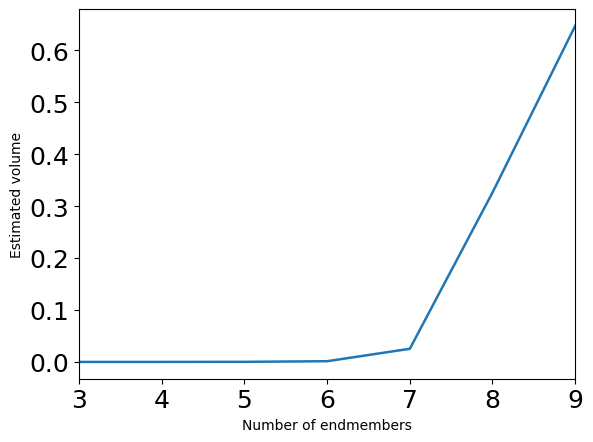

In [15]:
# Plot the volume estimation figure
endmem = np.arange(3, num_endmember + 1)
plt.figure()
plt.plot(endmem, gen_gram_matrix[2:num_endmember], linewidth=1.8)
plt.xlabel('Number of endmembers')
plt.ylabel('Estimated volume')
plt.xlim([3, num_endmember])
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()

In [16]:
# Compute endmembers
Endmembers, endmember_index = MaxD_Endmembers(I_sphere_bin, I_sphere_bin, 9)

In [17]:
#Now that we have the endmembers, let's classify the image using them

m, n, l = img.shape
hcuben_reshaped = img.reshape(m * n, l)

In [18]:
print(f"Endmembers shape: {Endmembers.shape}")
print(f"hcuben_reshaped shape: {hcuben_reshaped.shape}")


Endmembers shape: (270, 9)
hcuben_reshaped shape: (220000, 270)


In [19]:
# Estimate abundance using least squares method
abundanceMap = np.linalg.lstsq(Endmembers, hcuben_reshaped.T, rcond=-1)[0]
abundanceMap = abundanceMap.T.reshape(m, n, 9)

classNames = ['class 1', 'class 2', 'class 3', 'class 4', 'class 5', 'class 6', 'class 7','class 8','class 9']

In [20]:
print(f"abundanceMap shape before reshape: {abundanceMap.shape}")
print(f"Expected size for reshape: {550 * 400 * 9}")

abundanceMap shape before reshape: (550, 400, 9)
Expected size for reshape: 1980000


In [21]:
# Match indexes for plotting
matchIdx = np.argmax(abundanceMap, axis=2)

[]

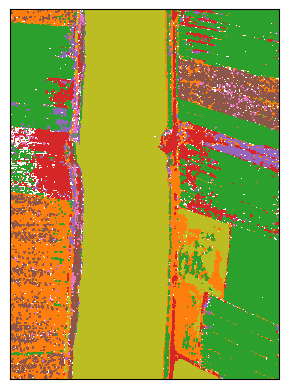

In [22]:
# Plot the abundance map
plt.figure()
for i in range(1, 9):
    plt.contourf(np.where(matchIdx == i, i, np.nan), levels=[i-0.5, i+0.5], colors=[plt.cm.tab10(i)])
plt.gca().set_aspect('equal', adjustable='box')
plt.gca().invert_yaxis()
plt.gca().set_xticks([])
plt.gca().set_yticks([])

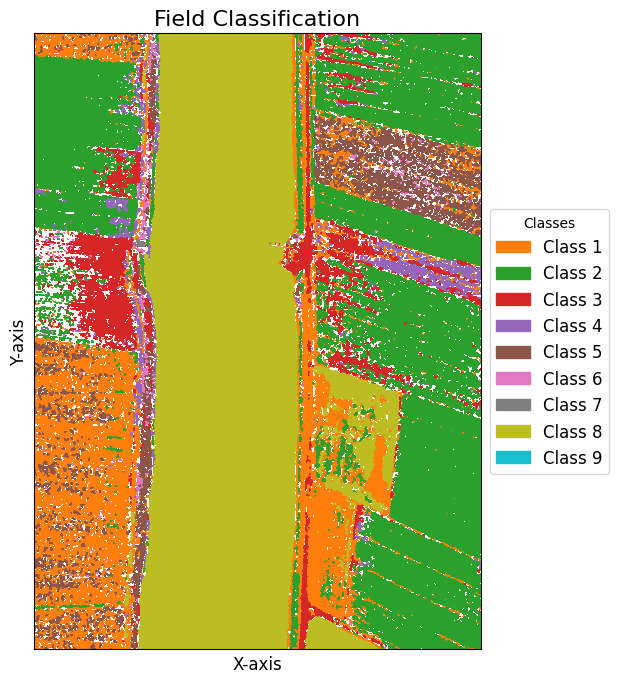

In [23]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Plot the abundance map
plt.figure(figsize=(10, 8))  # Adjust the figure size if necessary

# Plot each class with its own contour
for i in range(1, 9):
    plt.contourf(np.where(matchIdx == i, i, np.nan), levels=[i-0.5, i+0.5], colors=[plt.cm.tab10(i)])

# Set aspect ratio to equal for proper scaling
plt.gca().set_aspect('equal', adjustable='box')

# Invert Y-axis to match image coordinates
plt.gca().invert_yaxis()

# Remove ticks from both axes
plt.gca().set_xticks([])
plt.gca().set_yticks([])

# Set title and labels
plt.title("Field Classification", fontsize=16)
plt.xlabel("X-axis", fontsize=12)  # Adjust if needed
plt.ylabel("Y-axis", fontsize=12)  # Adjust if needed

# Create legend for class names (using class names and colors)
legend_patches = [
    mpatches.Patch(color=plt.cm.tab10(i / 10), label=f'Class {i}')
    for i in range(1, 10)
]

# Add legend with class names beside the plot
plt.legend(handles=legend_patches, loc='center left', bbox_to_anchor=(1, 0.5), title="Classes", fontsize=12)

# Display the plot
plt.show()


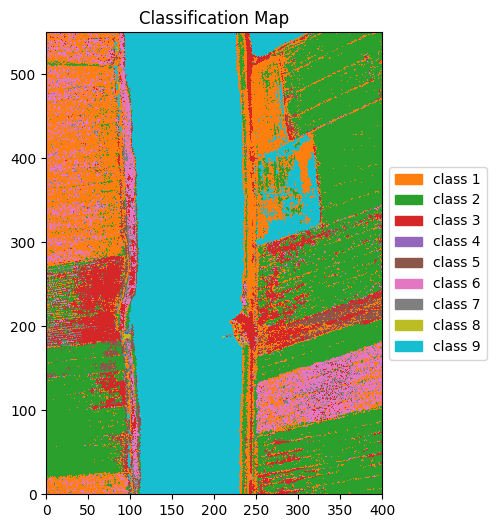

In [24]:
plt.figure(figsize=(8, 6))

# Plot the classification map
plt.imshow(matchIdx, cmap=plt.cm.tab10, interpolation='none')

# Ensure the axes cover the full array dimensions
plt.xlim(0, matchIdx.shape[1])
plt.ylim(0, matchIdx.shape[0])

# Add a colorbar for reference
#plt.colorbar(ticks=range(10), label="Class Indices")
plt.title("Classification Map")

# Display the legend (if relevant)
legend_patches = [
    mpatches.Patch(color=plt.cm.tab10(i / 10), label=classNames[i - 1]) 
    for i in range(1, 10)
]
plt.legend(handles=legend_patches, loc='center left', bbox_to_anchor=(1, 0.5))

# Show the plot
plt.show()


In [26]:
import spectral as sp
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Path to the label files
bsq_file = "/kaggle/input/whu-hi-longkou/WHU-Hi-LongKou_gt.bsq"
hdr_file = "/kaggle/input/whu-hi-longkou/WHU-Hi-LongKou_gt.hdr"

# Load the data using the spectral library
labels = spy.open_image(hdr_file).load()

# Verify the shape of the labels
print(f"Labels shape: {labels.shape}")


Labels shape: (550, 400, 1)


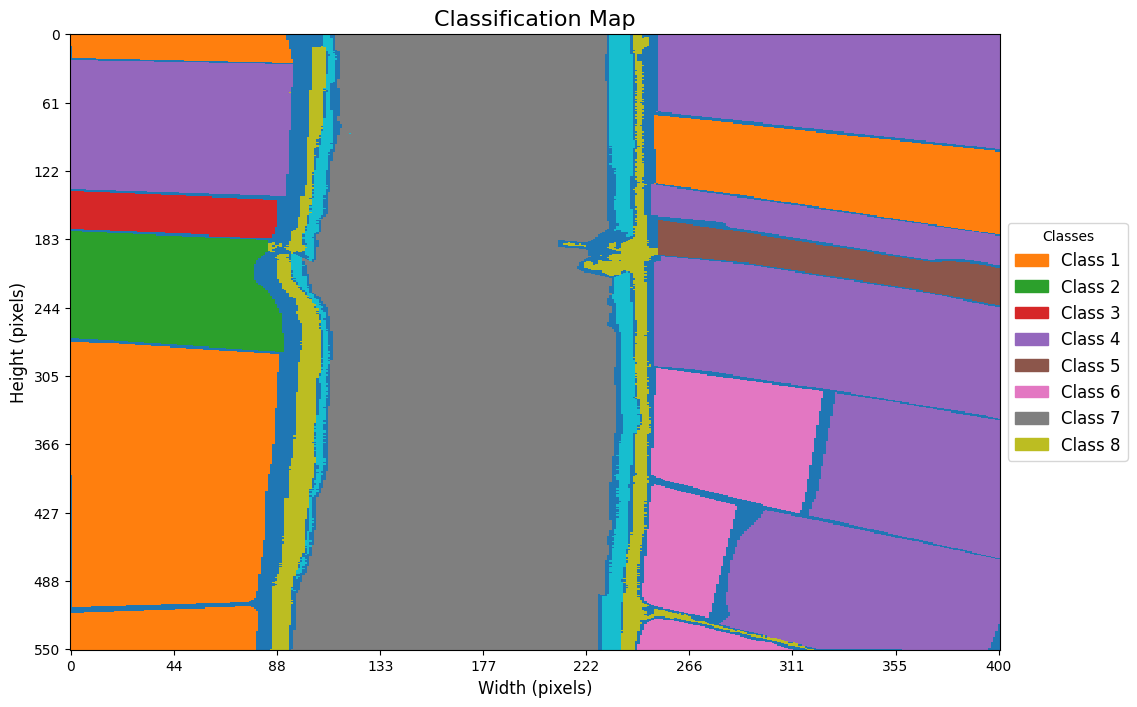

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Assume `labels` is loaded with shape (550, 400, 1)
# Remove the extra dimension to make it 2D
labels = np.squeeze(labels)  # Or labels = labels[:, :, 0]

# Get the image dimensions
height, width = labels.shape

# Define the number of classes
num_classes = 9  # Adjust based on the actual number of classes

# Create a classification map
plt.figure(figsize=(12, 8))

# Plot the classification map using discrete colormap
plt.imshow(labels, cmap=plt.cm.tab10, interpolation="nearest", aspect="auto")

# Add color-coded legend for the classes
legend_patches = [
    mpatches.Patch(color=plt.cm.tab10(i / num_classes), label=f"Class {i}")
    for i in range(1, num_classes)
]
plt.legend(
    handles=legend_patches,
    loc="center left",
    bbox_to_anchor=(1, 0.5),
    title="Classes",
    fontsize=12,
)

# Add axes labels and title
plt.xlabel("Width (pixels)", fontsize=12)
plt.ylabel("Height (pixels)", fontsize=12)
plt.title("Classification Map", fontsize=16)

# Ensure axis ticks correspond to the image size
plt.xticks(np.linspace(0, width - 1, num=10), np.linspace(0, width, num=10, dtype=int))
plt.yticks(np.linspace(0, height - 1, num=10), np.linspace(0, height, num=10, dtype=int))

# plt.colorbar(label="Class Index", orientation="vertical")
plt.show()


In [28]:
labels = np.squeeze(labels)


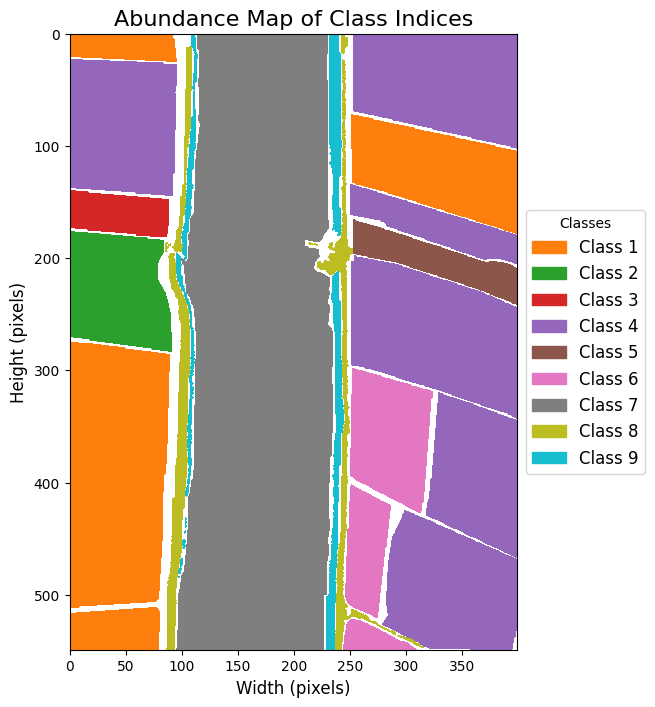

In [29]:
# Remove the extra dimension
labels = np.squeeze(labels)  # Or labels = labels[:, :, 0]

# Plot each class with its own color
plt.figure(figsize=(12, 8))
for i in range(1, 10):  # Adjust based on the number of classes
    plt.contourf(
        np.where(labels == i, i, np.nan),
        levels=[i - 0.5, i + 0.5],
        colors=[plt.cm.tab10(i / 10)]
    )

# Set axis properties
plt.gca().set_aspect('equal', adjustable='box')
plt.gca().invert_yaxis()
plt.xlabel("Width (pixels)", fontsize=12)
plt.ylabel("Height (pixels)", fontsize=12)

# Add a title and legend
plt.title("Abundance Map of Class Indices", fontsize=16)
legend_patches = [
    mpatches.Patch(color=plt.cm.tab10(i / 10), label=f"Class {i}")
    for i in range(1, 10)
]
plt.legend(
    handles=legend_patches,
    loc="center left",
    bbox_to_anchor=(1, 0.5),
    title="Classes",
    fontsize=12
)

plt.show()


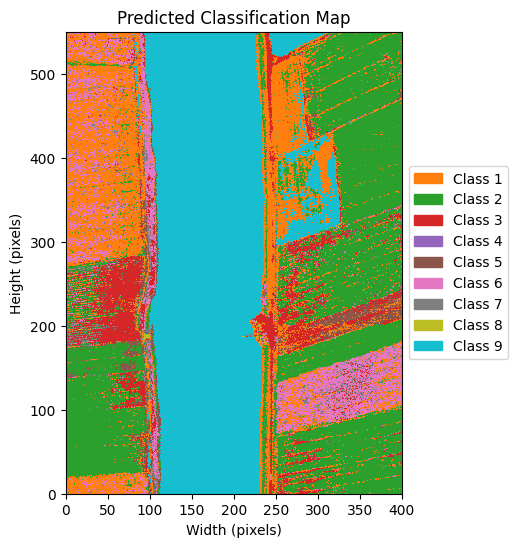

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# matchIdx should have shape (height, width), where each pixel value is a class index
height, width = matchIdx.shape

# List of class names 
classNames = ['Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5', 'Class 6', 'Class 7', 'Class 8', 'Class 9']

# Create a figure
plt.figure(figsize=(8, 6))

# Plot the classification map with the predicted class indices
plt.imshow(matchIdx, cmap=plt.cm.tab10, interpolation='none')

# Ensure the axes cover the full array dimensions
plt.xlim(0, matchIdx.shape[1])
plt.ylim(0, matchIdx.shape[0])

# Add title
plt.title("Predicted Classification Map")

# Add axis labels
plt.xlabel("Width (pixels)")
plt.ylabel("Height (pixels)")

# Display the colorbar for reference (with ticks for class indices)
#plt.colorbar(ticks=range(10), label="Class Indices")

# Display the legend for class names
legend_patches = [
    mpatches.Patch(color=plt.cm.tab10(i / 10), label=classNames[i - 1]) 
    for i in range(1, 10)
]
plt.legend(handles=legend_patches, loc='center left', bbox_to_anchor=(1, 0.5))

# Show the plot
plt.show()


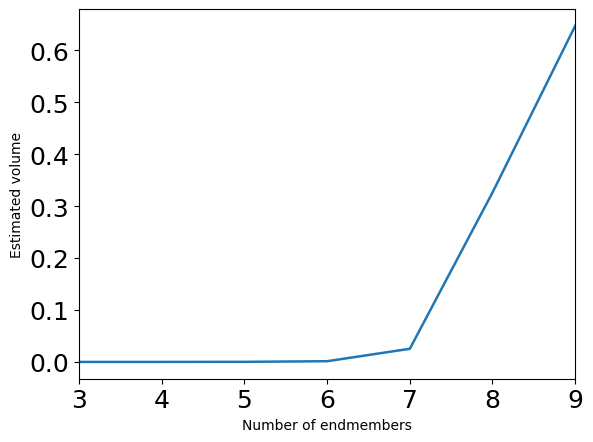

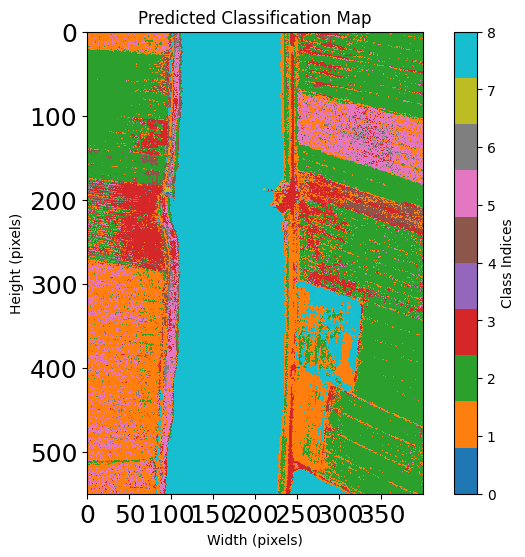

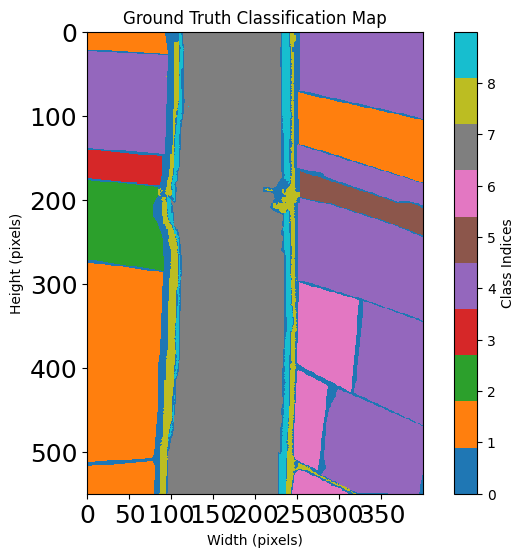

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import svd, pinv
from sklearn.decomposition import PCA
import spectral as spy
import matplotlib.patches as mpatches

def hypermnf(cube, numComponents, mean_centered=True):
    h, w, channels = cube.shape
    cube = cube.reshape(h * w, channels)
    
    if mean_centered:
        u = np.mean(cube, axis=0)
        cube -= u

    V = np.diff(cube, axis=0)
    V = computeCov(V)
    
    U, S, _ = svd(V, full_matrices=False)
    getNonZeros = np.sum(S != 0)
    U = U[:, :getNonZeros]
    
    noiseWhitening = np.dot(U, np.diag(1 / np.sqrt(S[:getNonZeros]))).T
    
    cube = np.dot(noiseWhitening, cube.T).T
    
    pca = PCA(n_components=numComponents, svd_solver='full')
    reduced_cube = pca.fit_transform(cube)
    
    coeff = np.dot(pca.components_.T, noiseWhitening.T)
    
    return reduced_cube.reshape(h, w, numComponents), coeff

def computeCov(cube):
    return np.cov(cube, rowvar=False)

def MaxD_Endmembers(MData, MData2, N):
    Data = MData.T
    Data1 = MData2.T
    nb, pix = Data.shape
    npc, _ = Data1.shape
    magnitude = np.sum(Data**2, axis=0)
    idx1 = np.argmax(magnitude)
    idx2 = np.argmin(magnitude)
    
    Endmembers = np.zeros((npc, N))
    idxEndmembers = np.zeros(N, dtype=int)
    
    Endmembers[:, 0] = Data[:, idx1]
    Endmembers[:, 1] = Data[:, idx2]
    idxEndmembers[0] = idx1
    idxEndmembers[1] = idx2
    
    Data_proj = Data1.copy()
    Id = np.eye(npc)
    
    for k in range(2, N):
        difference1 = Data_proj[:, idx2] - Data_proj[:, idx1]
        Dps = pinv(difference1[:, np.newaxis])
        ProjD = Id - np.dot(difference1[:, np.newaxis], Dps)
        Data_proj = np.dot(ProjD, Data_proj)
        idx1 = idx2
        Res = np.sum((Data_proj[:, idx2][:, np.newaxis] - Data_proj) ** 2, axis=0)
        idx2 = np.argmax(Res)
        Endmembers[:, k] = Data[:, idx2]
        idxEndmembers[k] = idx2
        
    return Endmembers, idxEndmembers

def local_gram(Endmembers):
    return np.dot(Endmembers.T, Endmembers)

def general_gram(Endmembers):
    mean_endmembers = np.mean(Endmembers, axis=1)
    centered_endmembers = Endmembers - mean_endmembers[:, np.newaxis]
    return np.dot(centered_endmembers.T, centered_endmembers)

def cal_vol_func(Data, MNF_data, num_endmembers):
    loc_gram_fcn = np.zeros(num_endmembers)
    gen_gram_fcn = np.zeros(num_endmembers)
    
    for i in range(2, num_endmembers):
        Endmembers, _ = MaxD_Endmembers(Data, MNF_data, i + 1)
        loc_gram = local_gram(Endmembers)
        loc_gram_fcn[i] = np.sqrt(abs(np.linalg.det(loc_gram)))
        gen_gram = general_gram(Endmembers)
        gen_gram_fcn[i] = np.sqrt(abs(np.linalg.det(gen_gram)))
        
    return np.vstack((loc_gram_fcn, gen_gram_fcn))

# Main script execution
datafile = '/kaggle/input/whu-hi-longkou/WHU-Hi-LongKou.bsq'
hdrfile = '/kaggle/input/whu-hi-longkou/WHU-Hi-LongKou.hdr'

# Load the hyperspectral image using spectral library
hcube = spy.open_image(hdrfile)
img = hcube.load().astype(np.float64)

# Load the ground truth labels using the spectral library (adjust paths accordingly)
bsq_file = '/kaggle/input/whu-hi-longkou/WHU-Hi-LongKou_gt.bsq'  # Ground truth labels file
hdr_file = '/kaggle/input/whu-hi-longkou/WHU-Hi-LongKou_gt.hdr'  # Header for ground truth

gt_cube = spy.open_image(hdr_file)
gt_labels = gt_cube.load().astype(np.int32)  # Ensure the data type matches (e.g., integer class indices)

# Check and adjust the shape if necessary
gt_labels = gt_labels[:, :, 0]  # Remove any extra dimension if it exists

img = img[:, :, :270]  # Slice if needed to match dimensions (151 bands in this case)

num_endmember = 9
I_sphere_bin = img.reshape(-1, 270)
MNFD = hypermnf(img, 270)[0].reshape(550 * 400, 270)
fcn_array = cal_vol_func(I_sphere_bin, MNFD, num_endmember)

# Compute ratio of general gram matrix
gen_gram_matrix = fcn_array[1, :]
gen_gram_matrix = gen_gram_matrix / np.sum(gen_gram_matrix)

# Plot the volume estimation figure
endmem = np.arange(3, num_endmember + 1)
plt.figure()
plt.plot(endmem, gen_gram_matrix[2:num_endmember], linewidth=1.8)
plt.xlabel('Number of endmembers')
plt.ylabel('Estimated volume')
plt.xlim([3, num_endmember])
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()

# Compute endmembers
Endmembers, endmember_index = MaxD_Endmembers(I_sphere_bin, I_sphere_bin, 9)

# Now that we have the endmembers, let's classify the image using them
m, n, l = img.shape
hcuben_reshaped = img.reshape(m * n, l)

# Estimate abundance using least squares method
abundanceMap = np.linalg.lstsq(Endmembers, hcuben_reshaped.T, rcond=-1)[0]
abundanceMap = abundanceMap.T.reshape(m, n, 9)

classNames = ['class 1', 'class 2', 'class 3', 'class 4', 'class 5', 'class 6', 'class 7','class 8','class 9']

# Match indexes for plotting
matchIdx = np.argmax(abundanceMap, axis=2)

# Plot the predicted abundance map
plt.figure(figsize=(8, 6))
plt.imshow(matchIdx, cmap=plt.cm.tab10, interpolation='none')
plt.title("Predicted Classification Map")
plt.colorbar(ticks=range(9), label="Class Indices")
plt.xlabel("Width (pixels)")
plt.ylabel("Height (pixels)")
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()

# Plot the ground truth classification map
plt.figure(figsize=(8, 6))
plt.imshow(gt_labels, cmap=plt.cm.tab10, interpolation='none')
plt.title("Ground Truth Classification Map")
plt.colorbar(ticks=range(9), label="Class Indices")
plt.xlabel("Width (pixels)")
plt.ylabel("Height (pixels)")
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()

